# Privacy Meter Demo: Auditing Differential Privacy Lower Bound

## Setting up the Colab environment

If you are running it offline, you can skip to "Importing"

In [ ]:
# Clone the github repo
!git clone https://github.com/privacytrustlab/ml_privacy_meter.git

# Update the Colab environment
%pip install datasets==2.21.0 transformers==4.44.2 torch==2.4.1 torchvision==0.19.1 torchaudio

# install DP training libaries
%pip install opacus

In [ ]:
# Change the directory to the cloned repo
import sys
sys.path.append('/content/ml_privacy_meter')

%cd ml_privacy_meter

## Importing

In [1]:
import math
import time

import numpy as np
import torch
import yaml
from torch.utils.data import Subset

from audit import get_average_audit_results, audit_models, get_all_dp_audit_results, get_dp_audit_results_for_k_pos_k_neg
from get_signals import get_model_signals
from models.utils import dp_load_models, train_models, dp_train_models
from util import (
    check_configs,
    setup_log,
    initialize_seeds,
    create_directories,
    load_dataset,
    load_canary_dataset,
    split_dataset_for_training_poisson
)

# Enable benchmark mode in cudnn to improve performance when input sizes are consistent
torch.backends.cudnn.benchmark = True

/home/ubuntu/anaconda3/envs/privacy_meter/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load config

In [2]:
configs = "configs/cifar10_dp_train_mislabel_1000.yaml"
with open(configs, "rb") as f:
        configs = yaml.load(f, Loader=yaml.Loader)

# Validate configurations
check_configs(configs)

## Setting up

In [3]:
# Validate configurations
check_configs(configs)

# Initialize seeds for reproducibility
initialize_seeds(configs["run"]["random_seed"])

# Create necessary directories
log_dir = configs["run"]["log_dir"]
directories = {
    "log_dir": log_dir,
    "report_dir": f"{log_dir}/report",
    "signal_dir": f"{log_dir}/signals",
    "data_dir": configs["data"]["data_dir"],
}
create_directories(directories)

# Set up logger
logger = setup_log(
    directories["report_dir"], "time_analysis", configs["run"]["time_log"]
)

start_time = time.time()

## Load (canary) dataset

In [4]:
baseline_time = time.time()
if configs['dp_audit'].get('canary_dataset', 'none') == 'none':
    dataset, population = load_dataset(configs, directories["data_dir"], logger)
    canary_dataset = torch.utils.data.Subset(
        dataset, np.arange(configs['dp_audit']['canary_size'])
    )
elif configs['dp_audit'].get('canary_dataset', 'none') == 'cifar10_canary':
    canary_dataset, _ = load_canary_dataset(configs, directories["data_dir"], logger)
    if configs["dp_audit"]['canary_size']>len(canary_dataset):
        raise ValueError("canary data size cannot be larger than the whole cifar10 dataset.")
    canary_dataset = torch.utils.data.Subset(
        canary_dataset, np.arange(configs['dp_audit']['canary_size'])
    )
    clean_dataset, population = load_dataset(configs, directories["data_dir"], logger)
    # subsample clean dataset to ensure that the number of clean samples + the number of canary samples = size of the whole training dataset
    clean_dataset = torch.utils.data.Subset(
        clean_dataset, np.arange(configs['dp_audit']['canary_size'], len(clean_dataset))
    )
    dataset = torch.utils.data.ConcatDataset([canary_dataset, clean_dataset])
else:
    raise NotImplementedError(f"canary dataset {configs['dp_audit']} is not supported")

logger.info("Loading dataset took %0.5f seconds", time.time() - baseline_time)


2025-02-06 13:09:03,668 INFO     Data loaded from data/cifar10_canary.pkl
2025-02-06 13:09:03,682 INFO     Population data loaded from data/cifar10_canary_population.pkl
2025-02-06 13:09:03,683 INFO     The whole dataset size: 50000
2025-02-06 13:09:03,747 INFO     Data loaded from data/cifar10.pkl
2025-02-06 13:09:03,761 INFO     Population data loaded from data/cifar10_population.pkl
2025-02-06 13:09:03,762 INFO     The whole dataset size: 50000
2025-02-06 13:09:03,763 INFO     Loading dataset took 0.16872 seconds


## Load or train models

In [5]:
# Define experiment parameters
num_experiments = configs["run"]["num_experiments"]
num_reference_models = configs["audit"]["num_ref_models"]
num_model_pairs = max(math.ceil(num_experiments / 2.0), num_reference_models + 1)

# Load or train models
baseline_time = time.time()
models_list, memberships = dp_load_models(
    log_dir, dataset, num_model_pairs * 2, configs, logger
)
if models_list is None:
    # Split dataset for training two models per pair
    data_splits, memberships = split_dataset_for_training_poisson(
        len(dataset), num_model_pairs
    )
    if configs['dp_audit']['training_alg'] == 'dp':
        models_list = dp_train_models(
            log_dir, dataset, data_splits, memberships, configs, logger
        ) 
    elif configs['dp_audit']['training_alg'] == 'nondp':
        models_list = train_models(
            log_dir, dataset, data_splits, memberships, configs, logger
        )
logger.info(
    "Model loading/training took %0.1f seconds", time.time() - baseline_time
)


2025-02-06 13:09:06,216 INFO     Loading model 0
/home/ubuntu/anaconda3/envs/privacy_meter/lib/python3.12/site-packages/opacus/utils/module_utils.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to th

## Prepare auditing dataset

In [6]:
auditing_dataset = canary_dataset
auditing_membership = memberships[
        :, : len(canary_dataset)
    ].reshape((memberships.shape[0], len(canary_dataset)))

population = torch.utils.data.Subset(
    population,
    np.random.choice(
        len(population),
        configs["audit"].get("population_size", len(population)),
        replace=False,
    ),
)

## Compute signals

In [7]:
# Generate signals (softmax outputs) for all models
baseline_time = time.time()
signals = get_model_signals(models_list, auditing_dataset, configs, logger)
population_signals = get_model_signals(
    models_list, population, configs, logger, is_population=True
)
logger.info("Preparing signals took %0.5f seconds", time.time() - baseline_time)


2025-02-06 13:09:11,979 INFO     Signals loaded from disk successfully.
02/06/2025 13:09:11:INFO:Signals loaded from disk successfully.
2025-02-06 13:09:11,982 INFO     Signals loaded from disk successfully.
02/06/2025 13:09:11:INFO:Signals loaded from disk successfully.
2025-02-06 13:09:11,984 INFO     Preparing signals took 0.00614 seconds
02/06/2025 13:09:11:INFO:Preparing signals took 0.00614 seconds


## Audit

In [8]:
# Perform the privacy audit
baseline_time = time.time()
target_model_indices = list(range(num_experiments))
mia_score_list, membership_list = audit_models(
    f"{directories['report_dir']}/exp",
    target_model_indices,
    signals,
    population_signals,
    auditing_membership,
    num_reference_models,
    logger,
    configs,
)

get_all_dp_audit_results(directories["report_dir"], mia_score_list, membership_list, logger)


# k_neg = 900
# k_pos = 59700
# get_dp_audit_results_for_k_pos_k_neg(directories["report_dir"], mia_score_list, membership_list, logger, k_pos, k_neg)

if len(target_model_indices) > 1:
    logger.info(
        "Auditing privacy risk took %0.1f seconds", time.time() - baseline_time
    )

# Get average audit results across all experiments
if len(target_model_indices) > 1:
    get_average_audit_results(
        directories["report_dir"], mia_score_list, membership_list, logger
    )

logger.info("Total runtime: %0.5f seconds", time.time() - start_time)


2025-02-06 13:09:14,046 INFO     Fine-tuning offline_a using paired model 1
02/06/2025 13:09:14:INFO:Fine-tuning offline_a using paired model 1
2025-02-06 13:09:14,075 INFO     offline_a=0.00: AUC 0.5540
02/06/2025 13:09:14:INFO:offline_a=0.00: AUC 0.5540
2025-02-06 13:09:14,093 INFO     offline_a=0.10: AUC 0.5542
02/06/2025 13:09:14:INFO:offline_a=0.10: AUC 0.5542
2025-02-06 13:09:14,125 INFO     offline_a=0.20: AUC 0.5543
02/06/2025 13:09:14:INFO:offline_a=0.20: AUC 0.5543
2025-02-06 13:09:14,157 INFO     offline_a=0.30: AUC 0.5543
02/06/2025 13:09:14:INFO:offline_a=0.30: AUC 0.5543
2025-02-06 13:09:14,176 INFO     offline_a=0.40: AUC 0.5543
02/06/2025 13:09:14:INFO:offline_a=0.40: AUC 0.5543
2025-02-06 13:09:14,194 INFO     offline_a=0.50: AUC 0.5551
02/06/2025 13:09:14:INFO:offline_a=0.50: AUC 0.5551
2025-02-06 13:09:14,217 INFO     offline_a=0.60: AUC 0.5556
02/06/2025 13:09:14:INFO:offline_a=0.60: AUC 0.5556
2025-02-06 13:09:14,248 INFO     offline_a=0.70: AUC 0.5565
02/06/2025 1

<Figure size 640x480 with 0 Axes>

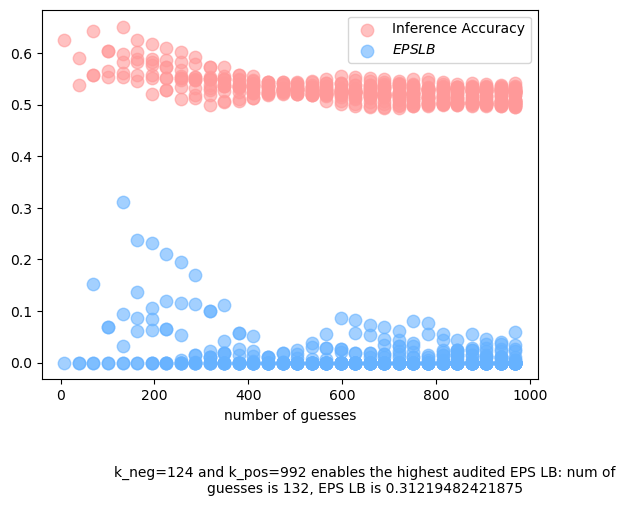

In [9]:
from IPython.display import Image
Image(f"{log_dir}/report/dp_audit_average.png")